In [25]:
import numpy as np
import torch
from time import time
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader

import sys
sys.path.append("/home/zihao/llm/llm4rec")

from index.datasets import EmbDataset
from index.models.rqvae import RQVAE

import polars as pl

In [23]:
CATEGORY = "Movies_and_TV"
DATA_DIR = Path("/home/zihao/llm/llm4rec/data")

### 模型加载与item sid转化

In [4]:
ckpt_path = "/home/zihao/llm/llm4rec/index/ckpt/scale12.0/Jan-06-2026_10-39-41/best_collision_model.pth"
data_path = "/home/zihao/llm/llm4rec/data/output/Movies_and_TV_combine_clean_embeddings.parquet"

device = torch.device("cuda")

ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'), weights_only=False)
args = ckpt["args"]
state_dict = ckpt["state_dict"]

data = EmbDataset(data_path, scale=12.0)

model = RQVAE(in_dim=data.dim,
              num_emb_list=args.num_emb_list,
              e_dim=args.e_dim,
              layers=args.layers,
              dropout_prob=args.dropout_prob,
              bn=args.bn,
              loss_type=args.loss_type,
              quant_loss_weight=args.quant_loss_weight,
              kmeans_init=args.kmeans_init,
              kmeans_iters=args.kmeans_iters,
              sk_epsilons=args.sk_epsilons,
              sk_iters=args.sk_iters,
              )

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()
print(model)

RQVAE(
  (encoder): MLPLayers(
    (mlp_layers): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.0, inplace=False)
      (5): Linear(in_features=512, out_features=256, bias=True)
      (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout(p=0.0, inplace=False)
      (9): Linear(in_features=256, out_features=128, bias=True)
      (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Dropout(p=0.0, inplace=False)
      (13): Linear(in_features=128, out_features=64, bias=True)
      (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (15): ReLU()
      (16): Dropout(p=0.0, inplace=False)
      (17): Linear(in_features=6

In [9]:
data_loader = DataLoader(data,num_workers=args.num_workers,
                         batch_size=64, shuffle=False,
                         pin_memory=True)

all_indices = []

for d in tqdm(data_loader):
    d = d.to(device)
    indices = model.get_indices(d, use_sk=False)
    indices = indices.view(-1, indices.shape[-1]).cpu().tolist()
    all_indices.extend(indices)

100%|██████████| 635/635 [00:02<00:00, 278.76it/s]


In [18]:
items_combine_df = pl.read_csv("/home/zihao/llm/llm4rec/data/output/Movies_and_TV_combine_clean.csv")

# 将all_indices的每一行（三个sid）加入到items_combine_df中
# 假设all_indices shape 是 (num_items, 3)
semantic_ids_array = np.array(all_indices)
result_df = items_combine_df.with_columns([
    pl.Series("semantic_id_0", semantic_ids_array[:, 0]),
    pl.Series("semantic_id_1", semantic_ids_array[:, 1]),
    pl.Series("semantic_id_2", semantic_ids_array[:, 2]),
])
result_df.head(5)

parent_asin,clean_combine,semantic_id_0,semantic_id_1,semantic_id_2
str,str,i64,i64,i64
"""B00FMR66J0""","""Title: Psych: The Musical Cate…",58,128,27
"""B01H3KUHQQ""","""Title: HEE HAW: COLLECTOR'S ED…",236,245,106
"""B001KY34FS""","""Title: Hollywood Canteen Categ…",37,231,144
"""B00S03O10Y""","""Title: Carrington Category: Dr…",118,84,132
"""B00HVTRDZ8""","""Title: Norma Rae: 35th Anniver…",124,237,179


### sid去重

In [19]:
# Add collision resolution - 4th code for items with same first 3 codes
print("\nResolving semantic ID collisions...")

# Group by the first 3 semantic IDs
collision_groups = (
    result_df.with_row_index("original_order")
    .group_by(["semantic_id_0", "semantic_id_1", "semantic_id_2"])
    .agg([pl.col("parent_asin"), pl.col("original_order"), pl.len().alias("group_size")])
    .sort(["semantic_id_0", "semantic_id_1", "semantic_id_2"])
)

# Show collision statistics
collision_counts = collision_groups.group_by("group_size").agg(pl.len().alias("n_groups")).sort("group_size")
print("Collision statistics:")
for row in collision_counts.iter_rows():
    group_size, n_groups = row
    print(f"  {n_groups:,} semantic ID combinations have {group_size} items")

# Create 4th code for each item
semantic_id_3_list = []

for row in collision_groups.iter_rows():
    sem_id_0, sem_id_1, sem_id_2, asins, orders, group_size = row

    # For each ASIN in this group, assign sequential 4th codes
    for idx, (asin, order) in enumerate(sorted(zip(asins, orders), key=lambda x: x[1])):
        semantic_id_3_list.append((order, idx))

# Sort by original order and extract just the 4th codes
semantic_id_3_list.sort(key=lambda x: x[0])
semantic_id_3_values = [x[1] for x in semantic_id_3_list]

# Add to dataframe
result_df = result_df.with_columns(pl.Series("semantic_id_3", semantic_id_3_values))

# Verify uniqueness
semantic_ids_full = result_df.select(
    pl.concat_str(
        [
            pl.col("semantic_id_0").cast(str),
            pl.col("semantic_id_1").cast(str),
            pl.col("semantic_id_2").cast(str),
            pl.col("semantic_id_3").cast(str),
        ],
        separator="-",
    ).alias("semantic_id_full")
)

n_unique_with_4th = semantic_ids_full["semantic_id_full"].n_unique()
print("After adding 4th code:")
print(f"  Total unique semantic ID combinations: {n_unique_with_4th:,} out of {len(result_df):,} items")
print(f"  Proportion of unique IDs: {n_unique_with_4th / len(result_df):.2%}")


Resolving semantic ID collisions...
Collision statistics:
  38,524 semantic ID combinations have 1 items
  856 semantic ID combinations have 2 items
  75 semantic ID combinations have 3 items
  16 semantic ID combinations have 4 items
  5 semantic ID combinations have 5 items
  2 semantic ID combinations have 6 items
  1 semantic ID combinations have 7 items
  1 semantic ID combinations have 11 items
After adding 4th code:
  Total unique semantic ID combinations: 40,580 out of 40,580 items
  Proportion of unique IDs: 100.00%


### 查看重复的sid对应的item信息

In [21]:
# 对于group_size（大于等于2）的情况，每种情况选一个group，打印parent_asin和clean_combine

# 找出所有 group_size >= 2 的 group
groups_multi = collision_groups.filter(pl.col("group_size") >= 2)
# 去重group_size
unique_sizes = groups_multi["group_size"].unique().to_list()

sampled_groups = []
for size in unique_sizes:
    subset = groups_multi.filter(pl.col("group_size") == size)
    if len(subset) > 0:
        row = subset.row(0)
        sem_id_0, sem_id_1, sem_id_2, asins, orders, group_size = row
        sampled_groups.append((sem_id_0, sem_id_1, sem_id_2, asins, group_size))

for sem_id_0, sem_id_1, sem_id_2, asins, group_size in sampled_groups:
    print(f"=== Group ({sem_id_0}, {sem_id_1}, {sem_id_2}) with group_size={group_size} ===")
    for asin in asins:
        match_row = result_df.filter(pl.col("parent_asin") == asin)
        parent_asin = match_row['parent_asin'][0]
        clean_combine = match_row['clean_combine'][0]
        print(f"ASIN: {parent_asin}\nclean_combine: {clean_combine}\n")


=== Group (0, 27, 3) with group_size=2 ===
ASIN: B00KM5F2V0
clean_combine: Title: Peppa Pig: The Balloon Ride
Category: Kids & Family, Animation
Identifiers: NR
Plot: Peppa Pig, a young pig, enjoys playing games, dressing up, and visiting new places. Her favorite activity is jumping in muddy puddles.
Language: English

ASIN: B01LTIABIM
clean_combine: Title: Peppa Pig: Around the World
Category: Kids & Family
Identifiers: NR
Plot: Peppa and her family plan a trip to the park to celebrate summer holidays. When their car breaks down, they borrow a plane and embark on a global adventure.
Language: English

=== Group (0, 59, 54) with group_size=3 ===
ASIN: 7883707728
clean_combine: Title: Sleeping Beauty (Mandarin Chinese Edition)
Category: Animation, Family, Fantasy, Musical
Identifiers: G
Plot: A king and queen have a daughter, Aurora, who is cursed by the evil sorceress Maleficent. Maleficent predicts Aurora will prick her finger on a spinning wheel and die on her 16th birthday. Three go

### 观测sid的层级信息

In [47]:
# 查看不同层级的sid划分效果

# Helper function for pretty print
import random

def print_sid_samples(df, filter_expr, sid_levels, n_samples=5, show_group_label=True):
    group_df = df.filter(filter_expr)
    total = len(group_df)
    if total == 0:
        print("No samples in this group.")
        return
    sample_df = group_df.sample(n=min(n_samples, total), shuffle=True) if total > n_samples else group_df
    if show_group_label and len(sample_df) > 0:
        group_info = ", ".join([f"{sid}={sample_df[sid][0]}" for sid in sid_levels])
        print(f"\n=== Sample for [{group_info}] (showing {len(sample_df)}/{total}) ===")
    for i, row in enumerate(sample_df.iter_rows()):
        print(f"  Sample {i+1}: {row[df.columns.index('clean_combine')]}")
    print()

def find_combinations_min_samples_for_hierarchy(
    df,
    min_count=5,
    n_combos=2,
    levels=None,
):
    """
    levels: 指定下钻的semantic_id层级，比如["semantic_id_0"], ["semantic_id_0", "semantic_id_1"], ["semantic_id_0", "semantic_id_1", "semantic_id_2"]
    """
    if levels is None:
        levels = ["semantic_id_0", "semantic_id_1", "semantic_id_2"]

    combos = []
    # Step 1: 顶层分组
    lv0 = levels[0]
    sid0_counts = (
        df.group_by([lv0])
        .len()
        .filter(pl.col("len") >= min_count)
    )
    available_lv0 = sid0_counts[lv0].to_list()
    random.shuffle(available_lv0)
    candidates_collected = 0

    for v0 in available_lv0:
        filters = [(pl.col(lv0) == v0)]
        # 钻取下一层级
        combo = [v0]
        sub_dfs = [df.filter(filters[0])]

        ok = True
        parent_vals = [(lv0, v0)]

        for lv_idx in range(1, len(levels)):
            lv_prev = levels[lv_idx - 1]
            lv_cur = levels[lv_idx]
            new_subs = []
            chosen_lv_vals = []

            for sub_df in sub_dfs:
                lv_counts = (
                    sub_df
                    .group_by([lv_cur])
                    .len()
                    .filter(pl.col("len") >= min_count)
                )
                vals = lv_counts[lv_cur].to_list()
                if len(vals) < 2:
                    ok = False
                    break
                chosen = random.sample(vals, 2)
                chosen_lv_vals.extend(chosen)
                for val in chosen:
                    new_subs.append(sub_df.filter(pl.col(lv_cur) == val))
            if not ok:
                break
            combo.append(chosen_lv_vals)
            sub_dfs = new_subs

        if ok:
            combos.append(tuple(combo))
            candidates_collected += 1
            if candidates_collected >= n_combos:
                break

    return combos

# 用法举例，可以灵活指定下钻层级
# 只下钻到两层
chosen_levels = ["semantic_id_0", "semantic_id_1"]
combos = find_combinations_min_samples_for_hierarchy(result_df, min_count=5, n_combos=2, levels=chosen_levels)
if len(combos) == 0:
    print(f"未找到全层级都满足条件的 {chosen_levels} 层级组合")
else:
    for idx, combo in enumerate(combos):
        print(f"\n=== Group Set {idx+1}: ===")
        v0 = combo[0]
        v1s = combo[1]
        # 展示1级示例
        print_sid_samples(
            result_df,
            (pl.col("semantic_id_0") == v0),
            ["semantic_id_0"],
        )
        for v1 in v1s:
            print_sid_samples(
                result_df,
                (pl.col("semantic_id_0") == v0) & (pl.col("semantic_id_1") == v1),
                ["semantic_id_0", "semantic_id_1"],
            )

# 如果你要三层，直接
# chosen_levels = ["semantic_id_0", "semantic_id_1", "semantic_id_2"]
# combos = find_combinations_min_samples_for_hierarchy(result_df, min_count=2, n_combos=2, levels=chosen_levels)


=== Group Set 1: ===

=== Sample for [semantic_id_0=34] (showing 5/659) ===
  Sample 1: Title:
Murder, She Wrote: Season Eleven
Category:
Drama, Mystery, Suspense
Identifiers:
Season 11, 21 episodes, NR
Plot:
A mystery writer's life is filled with intrigue and investigations. She travels the globe, solving crimes from her hometown to exotic locations. Her adventures are a page-turner for any crime lover.
Language:
English
  Sample 2: Title:
Monk: The Complete Series
Category:
Television, Mystery, Comedy
Identifiers:
NR
Plot:
An obsessive-compulsive detective lost his nerve, mind, and badge after a personal tragedy. He is determined to rejoin the police force by solving crimes.
Language:
English, Spanish, French
  Sample 3: Title: Father Dowling Mysteries
Category: Television, Crime
Identifiers: Season 1, NR
Plot: A Chicago priest solves crimes with the help of a nun. The priest is inquisitive, and the nun is worldly and skilled at lock-picking.
Language: English
  Sample 4: Title: Mag

✅ Group Set 1
semantic_id_0 = 34：整体特征：以 犯罪 / 悬疑 / 侦探电视剧 为核心的大类，长期连载、角色驱动、以案件为单元。
▸ semantic_id_1 = 52：经典侦探 IP 型子组
▸ semantic_id_1 = 97：现实主义 / 群像型犯罪剧子组

✅ Group Set 2
semantic_id_0 = 80：整体特征：科学 / 纪录片 / 探索类内容，以知识传播、事实解释为主。
▸ semantic_id_1 = 145：UFO / 外星 / 未解之谜主题子组
▸ semantic_id_1 = 50：主流科普 / 认知科学子组

### 添加sid字符串并保存

In [22]:
# Create a formatted semantic ID string for easy use
# Using the new format: <sid><SID_112><SID_291><SID_570><SID_768></sid>
# Where the token ID = level * 256 + value
result_df = result_df.with_columns(
    pl.concat_str(
        [
            pl.lit("<|sid_start|>"),
            pl.concat_str([pl.lit("<|sid_"), pl.col("semantic_id_0").cast(str), pl.lit("|>")]),
            pl.concat_str([pl.lit("<|sid_"), (256 + pl.col("semantic_id_1")).cast(str), pl.lit("|>")]),
            pl.concat_str([pl.lit("<|sid_"), (512 + pl.col("semantic_id_2")).cast(str), pl.lit("|>")]),
            pl.concat_str([pl.lit("<|sid_"), (768 + pl.col("semantic_id_3")).cast(str), pl.lit("|>")]),
            pl.lit("<|sid_end|>"),
        ],
        separator="",
    ).alias("semantic_id")
)

# Final summary
print("=== Final Semantic ID Summary ===")
print(f"Total items: {len(result_df):,}")
print("Semantic ID format: 4 codes (3 from RQ-VAE + 1 for collision resolution)")
print("New format: <sid><SID_112><SID_291><SID_570><SID_768></sid>")
print("Token mapping: SID_{level*256 + value}")
print("All semantic IDs are now unique!")

# Show distribution of 4th code values
fourth_code_dist = result_df.group_by("semantic_id_3").len().sort("semantic_id_3")
print("Distribution of 4th code values:")
for row in fourth_code_dist.head(10).iter_rows():
    code, count = row
    print(f"  Code {code}: {count:,} items")
if len(fourth_code_dist) > 10:
    print(f"  ... and {len(fourth_code_dist) - 10} more values")

# Final sample
print("Final semantic ID format:")
result_df.select(
    ["parent_asin", "semantic_id_0", "semantic_id_1", "semantic_id_2", "semantic_id_3", "semantic_id"]
).head(5)

=== Final Semantic ID Summary ===
Total items: 40,580
Semantic ID format: 4 codes (3 from RQ-VAE + 1 for collision resolution)
New format: <sid><SID_112><SID_291><SID_570><SID_768></sid>
Token mapping: SID_{level*256 + value}
All semantic IDs are now unique!
Distribution of 4th code values:
  Code 0: 39,480 items
  Code 1: 956 items
  Code 2: 100 items
  Code 3: 25 items
  Code 4: 9 items
  Code 5: 4 items
  Code 6: 2 items
  Code 7: 1 items
  Code 8: 1 items
  Code 9: 1 items
  ... and 1 more values
Final semantic ID format:


parent_asin,semantic_id_0,semantic_id_1,semantic_id_2,semantic_id_3,semantic_id
str,i64,i64,i64,i64,str
"""B00FMR66J0""",58,128,27,0,"""<|sid_start|><|sid_58|><|sid_3…"
"""B01H3KUHQQ""",236,245,106,0,"""<|sid_start|><|sid_236|><|sid_…"
"""B001KY34FS""",37,231,144,0,"""<|sid_start|><|sid_37|><|sid_4…"
"""B00S03O10Y""",118,84,132,0,"""<|sid_start|><|sid_118|><|sid_…"
"""B00HVTRDZ8""",124,237,179,0,"""<|sid_start|><|sid_124|><|sid_…"


In [26]:
# Save to parquet with updated semantic IDs (including 4th code)
output_path = DATA_DIR / "output" / f"{CATEGORY}_semantic_ids.parquet"
result_df.write_parquet(output_path)
print(f"Saved semantic IDs to {output_path}")

Saved semantic IDs to /home/zihao/llm/llm4rec/data/output/Movies_and_TV_semantic_ids.parquet


### 统计语义id分布

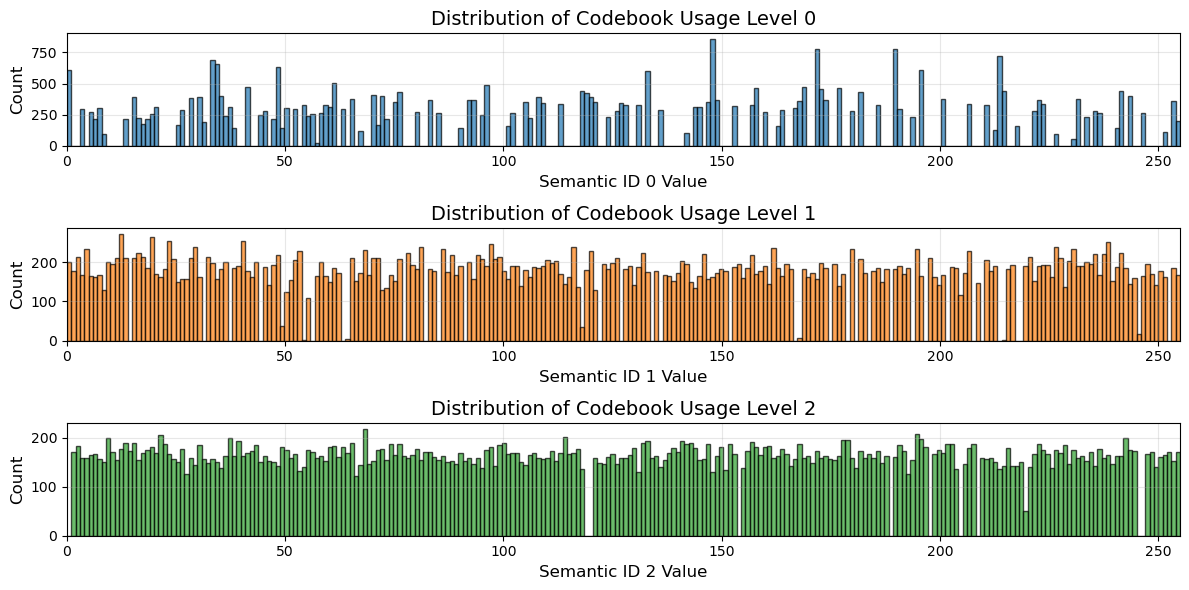

In [30]:
import matplotlib.pyplot as plt

# Create figure with 3 vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 6))

# Colors for each level
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Plot histogram for each semantic ID level
for level in range(3):
    col_name = f"semantic_id_{level}"
    values = result_df[col_name].to_list()

    axes[level].hist(values, bins=256, range=(0, 255), edgecolor="black", alpha=0.7, color=colors[level])
    axes[level].set_xlabel(f"Semantic ID {level} Value", fontsize=12)
    axes[level].set_xlim(0, 255)
    axes[level].set_ylabel("Count", fontsize=12)
    axes[level].set_title(f"Distribution of Codebook Usage Level {level}", fontsize=14)
    axes[level].grid(True, alpha=0.3)

    # Add statistics text

plt.tight_layout()
plt.show()

### 序列的sid转化

In [32]:
# Load sequences data
sequences_path_cold = DATA_DIR / "output" / f"{CATEGORY}_cold_user_sequences.parquet"
sequences_path_hot = DATA_DIR / "output" / f"{CATEGORY}_hot_user_sequences.parquet"

sequences_df_cold = pl.read_parquet(sequences_path_cold)
sequences_df_hot = pl.read_parquet(sequences_path_hot)

print(f"Loaded {sequences_df_cold.shape[0]:,} cold sequences")
print(f"Loaded {sequences_df_hot.shape[0]:,} hot sequences")

sequences_df = pl.concat([sequences_df_cold, sequences_df_hot])

Loaded 204 cold sequences
Loaded 38,189 hot sequences


In [33]:
# Create ASIN to semantic ID mapping dictionary (using data already in memory)
mapping_dict = dict(zip(result_df["parent_asin"], result_df["semantic_id"]))
print(f"Created mapping dictionary with {len(mapping_dict):,} ASIN -> semantic ID mappings")

# Check how many unique ASINs are in sequences
all_asins_in_sequences = set()
for sequence in sequences_df["sequence"]:
    all_asins_in_sequences.update(sequence)

print(f"Total unique ASINs in sequences: {len(all_asins_in_sequences):,}")
print(f"ASINs with semantic IDs: {len(mapping_dict):,}")

# Find ASINs without semantic IDs
asins_without_semantic_ids = all_asins_in_sequences - set(mapping_dict.keys())
print(
    f"ASINs without semantic IDs: {len(asins_without_semantic_ids):,} ({len(asins_without_semantic_ids) / len(all_asins_in_sequences) * 100:.1f}%)"
)

Created mapping dictionary with 40,580 ASIN -> semantic ID mappings
Total unique ASINs in sequences: 23,033
ASINs with semantic IDs: 40,580
ASINs without semantic IDs: 0 (0.0%)


In [34]:
# Define function to map sequences to semantic IDs
def map_sequence_to_semantic_ids(sequence):
    """Map a sequence of ASINs to their semantic IDs."""
    mapped = []
    for asin in sequence:
        if asin in mapping_dict:
            mapped.append(mapping_dict[asin])
        # Skip ASINs without semantic IDs
    return mapped


# Apply mapping to all sequences
sequences_df = sequences_df.with_columns(
    [
        pl.col("sequence")
        .map_elements(map_sequence_to_semantic_ids, return_dtype=pl.List(pl.Utf8))
        .alias("semantic_id_sequence"),
    ]
)

# Add length of semantic ID sequence
sequences_df = sequences_df.with_columns(
    [pl.col("semantic_id_sequence").list.len().alias("semantic_id_sequence_length")]
)

print(f"Mapped {sequences_df.shape[0]:,} sequences to semantic IDs")

Mapped 38,393 sequences to semantic IDs


In [35]:
# Show a sample of mapped sequences
print("\nSample mapped sequences:")
sequences_df.head(5)


Sample mapped sequences:


user_id,sequence,semantic_id_sequence,semantic_id_sequence_length
str,list[str],list[str],u32
"""AG3WUOBVLQCMMR7U4SQFENYVK6JQ""","[""6302443245"", ""6305183244"", … ""B0001G0HFQ""]","[""<|sid_start|><|sid_172|><|sid_284|><|sid_626|><|sid_768|><|sid_end|>"", ""<|sid_start|><|sid_95|><|sid_316|><|sid_659|><|sid_768|><|sid_end|>"", … ""<|sid_start|><|sid_41|><|sid_457|><|sid_747|><|sid_768|><|sid_end|>""]",11
"""AFXXHEHPTALPTJASXHRGON4PSZQA""","[""6304753365"", ""B0011ATJFK"", … ""B003RCJR3O""]","[""<|sid_start|><|sid_45|><|sid_415|><|sid_591|><|sid_768|><|sid_end|>"", ""<|sid_start|><|sid_118|><|sid_381|><|sid_639|><|sid_768|><|sid_end|>"", … ""<|sid_start|><|sid_28|><|sid_405|><|sid_525|><|sid_768|><|sid_end|>""]",18
"""AGWIU2DVVALEVN4DNKJ5CIBFU4JQ""","[""B07KK4P7S6"", ""B07MCM3WZC"", … ""B08CVSR32D""]","[""<|sid_start|><|sid_232|><|sid_348|><|sid_575|><|sid_768|><|sid_end|>"", ""<|sid_start|><|sid_224|><|sid_397|><|sid_651|><|sid_768|><|sid_end|>"", … ""<|sid_start|><|sid_194|><|sid_508|><|sid_565|><|sid_768|><|sid_end|>""]",5
"""AGFQF3FULPGUD2FQSCF27HA2C76Q""","[""6305010625"", ""6301978331"", … ""6301802012""]","[""<|sid_start|><|sid_118|><|sid_339|><|sid_524|><|sid_768|><|sid_end|>"", ""<|sid_start|><|sid_224|><|sid_298|><|sid_672|><|sid_768|><|sid_end|>"", … ""<|sid_start|><|sid_148|><|sid_296|><|sid_678|><|sid_768|><|sid_end|>""]",10
"""AFBTN4HATLZZKAAWRTEZMPLAWIXA""","[""B00176VK64"", ""6302069106"", … ""B003RY601Y""]","[""<|sid_start|><|sid_113|><|sid_397|><|sid_539|><|sid_768|><|sid_end|>"", ""<|sid_start|><|sid_182|><|sid_314|><|sid_580|><|sid_768|><|sid_end|>"", … ""<|sid_start|><|sid_224|><|sid_486|><|sid_634|><|sid_768|><|sid_end|>""]",6


In [36]:
# Save all mapped sequences
sequences_output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_with_semantic_ids.parquet"
sequences_df.write_parquet(sequences_output_path)
print(f"Saved mapped sequences to {sequences_output_path}")

Saved mapped sequences to /home/zihao/llm/llm4rec/data/output/Movies_and_TV_sequences_with_semantic_ids.parquet


### sequence切分训练集和验证集

In [38]:
# Set random seed for reproducibility
RANDOM_SEED = 42
VAL_SPLIT = 0.1  # 10% for validation

# Calculate split sizes
n_total = len(sequences_df)
n_val = int(n_total * VAL_SPLIT)
n_train = n_total - n_val

print("=" * 50)
print("Train/Validation Split:")
print(f"Total sequences: {n_total:,}")
print(f"Training sequences: {n_train:,} ({(n_train / n_total) * 100:.1f}%)")
print(f"Validation sequences: {n_val:,} ({(n_val / n_total) * 100:.1f}%)")
print("=" * 50)

# Perform random split
# Shuffle the sequences and split them
sequences_shuffled = sequences_df.sample(fraction=1.0, seed=RANDOM_SEED, shuffle=True)

# Split into train and validation
train_sequences = sequences_shuffled.head(n_train)
val_sequences = sequences_shuffled.tail(n_val)

# Verify split
assert len(train_sequences) + len(val_sequences) == n_total, "Split sizes don't match"
assert len(train_sequences) == n_train, f"Train size mismatch: {len(train_sequences)} != {n_train}"
assert len(val_sequences) == n_val, f"Val size mismatch: {len(val_sequences)} != {n_val}"

print("Split verification passed ✓")

Train/Validation Split:
Total sequences: 38,393
Training sequences: 34,554 (90.0%)
Validation sequences: 3,839 (10.0%)
Split verification passed ✓


In [39]:
# Check distribution of sequence lengths in both splits
print("\nSequence length distribution:")
print(
    f"Train - Mean: {train_sequences['semantic_id_sequence_length'].mean():.2f}, "
    f"Median: {train_sequences['semantic_id_sequence_length'].median():.0f}, "
    f"Min: {train_sequences['semantic_id_sequence_length'].min()}, "
    f"Max: {train_sequences['semantic_id_sequence_length'].max()}"
)
print(
    f"Val   - Mean: {val_sequences['semantic_id_sequence_length'].mean():.2f}, "
    f"Median: {val_sequences['semantic_id_sequence_length'].median():.0f}, "
    f"Min: {val_sequences['semantic_id_sequence_length'].min()}, "
    f"Max: {val_sequences['semantic_id_sequence_length'].max()}"
)


Sequence length distribution:
Train - Mean: 10.11, Median: 7, Min: 5, Max: 642
Val   - Mean: 10.49, Median: 7, Min: 5, Max: 447


In [40]:
# Save train and validation splits with appropriate suffixes
train_output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_with_semantic_ids_train.parquet"
val_output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_with_semantic_ids_val.parquet"

# Save train split
train_sequences.write_parquet(train_output_path)
print(f"Saved training sequences to {train_output_path}")

# Save validation split
val_sequences.write_parquet(val_output_path)
print(f"Saved validation sequences to {val_output_path}")

Saved training sequences to /home/zihao/llm/llm4rec/data/output/Movies_and_TV_sequences_with_semantic_ids_train.parquet
Saved validation sequences to /home/zihao/llm/llm4rec/data/output/Movies_and_TV_sequences_with_semantic_ids_val.parquet
